<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Brain_MRI/Main_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proejct Description

In this project i wanted to create a hybrid model.
I will call a hybrid model a model whcih is created by combining 2 models, one pretrained and one who is not trained

Our dataset consists of 4 different types of brain tumours:
- glioma
- meningioma
- notumor
- pituitary

The scope of this project is an educational one showing how we can use pretrained models to suit everyday problems by simply adding extra layers to the model

## Setting up the dependencies

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import requests
import zipfile
from pathlib import Path
import os
from torchvision import datasets

In [2]:
# Device agnostic code for using the available device
device= "cuda" if torch.cuda.is_available() else "cpu"

## Visualize one random image

Label: pituitary


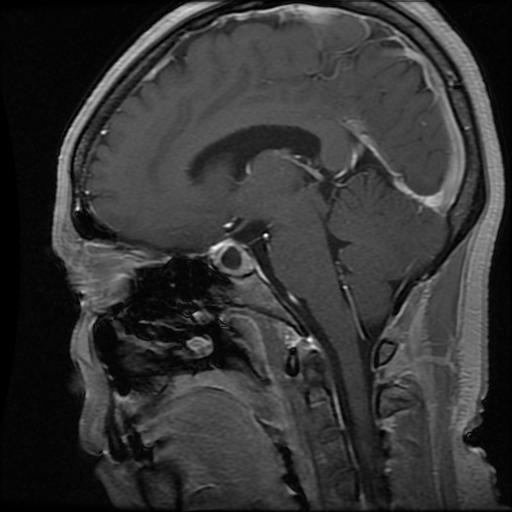

In [4]:
import random
from PIL import Image

image_path=Path(r"C:\Users\Debojyoti Das\Downloads\Brain Tumor Detection\archive")
image_path_list=list(image_path.glob("*/*/*.jpg"))
random_image_path=random.choice(image_path_list)

image_class=random_image_path.parent.stem
image=Image.open(random_image_path)
print(f"Label: {image_class}")
image

In [7]:
base_data_path = Path(r"C:\Users\Debojyoti Das\Downloads\Brain Tumor Detection\archive")
train_dir = base_data_path / "Training"
test_dir = base_data_path / "Testing"

## Creating the dataloaders

In [ ]:
# Creating a simple transform for our problem.
# We are using a random invert and random horizontal flip to augment our data

train_transform= transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomInvert(0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])

# For the test transform we haven't done any data augmentation , we want our model to guess the test data as it is.
# So we are just resizing and converting it to tensor

test_transform= transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

# Setting up the train data and test data
train_data=datasets.ImageFolder(train_dir,
                                transform=train_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(test_dir,
                               transform=test_transform)

# Creating the dataloaders, we are using a batch size of 32
train_dataloader=DataLoader(train_data,
                            batch_size=32,
                            shuffle=True)
test_dataloader=DataLoader(test_data,
                           batch_size=32,
                           shuffle=True)

# Creating the class names
class_names=train_data.classes

## Importing our pre-trained model and training it

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, ViT_B_16_Weights, DenseNet121_Weights

# Number of output classes for our specific task
NUM_CLASSES = 4 # glioma, meningioma, notumor, pituitary

def create_modified_model(model_name: str, num_classes: int = NUM_CLASSES):
    """
    Loads a specified pre-trained model from torchvision, freezes its base layers,
    and replaces the final classifier layer for the given number of classes.

    Args:
        model_name (str): The name of the torchvision model to load
                          (e.g., 'resnet50', 'efficientnet_b0', 'vit_b_16', 'densenet121').
        num_classes (int): The number of output classes for the new classifier head.

    Returns:
        torch.nn.Module: The modified pre-trained model ready for fine-tuning.
                         Returns None if the model name is not recognized.
    """
    print(f"--- Creating modified model: {model_name} ---")

    # Load the pre-trained model with default weights
    if model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        # Identify the original classifier layer and its input features
        num_ftrs = model.fc.in_features
        # Freeze all base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (fc)
        model.fc = nn.Linear(num_ftrs, num_classes)
        print(f"Replaced ResNet50 'fc' layer with new nn.Linear({num_ftrs}, {num_classes})")

    elif model_name == 'efficientnet_b0':
        weights = EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        # EfficientNet's classifier is within model.classifier[1]
        num_ftrs = model.classifier[1].in_features
        # Freeze all base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final linear layer within the classifier sequence
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        print(f"Replaced EfficientNet-B0 'classifier[1]' layer with new nn.Linear({num_ftrs}, {num_classes})")

    elif model_name == 'vit_b_16':
        weights = ViT_B_16_Weights.DEFAULT
        model = models.vit_b_16(weights=weights)
        # ViT's classifier head is model.heads.head
        num_ftrs = model.heads.head.in_features
        # Freeze all base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace the head
        model.heads.head = nn.Linear(num_ftrs, num_classes)
        print(f"Replaced ViT-B/16 'heads.head' layer with new nn.Linear({num_ftrs}, {num_classes})")
        # Note: ViT expects specific image size (e.g., 224x224 typically).
        # Ensure your transforms.Resize matches the expected input size or adjust here.
        # The DEFAULT weights for vit_b_16 expect 224. Let's update transforms later if needed.
        # For now, we'll assume the model can handle 256x256, but 224x224 is standard for ViT.

    elif model_name == 'densenet121':
        weights = DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        # DenseNet's classifier layer is model.classifier
        num_ftrs = model.classifier.in_features
        # Freeze all base layers
        for param in model.parameters():
            param.requires_grad = False
        # Replace the classifier
        model.classifier = nn.Linear(num_ftrs, num_classes)
        print(f"Replaced DenseNet-121 'classifier' layer with new nn.Linear({num_ftrs}, {num_classes})")

    else:
        print(f"Model '{model_name}' not recognized. Returning None.")
        return None

    print(f"Finished setup for {model_name}.")
    return model

### Here we are creating a modified version of our pretrained model because we want our model to adapt for our specific task. In order to do this we have added a small architecture(tiny-vgg)

In [ ]:
# Creating our custom model where we will combine the pretrained model with a simple one

class CustomModel(nn.Module):
  def __init__ (self,original_model):
    super().__init__()
    self.model=nn.Sequential(*list(original_model.children())[:-2])

    # Below we are creating another model

    self.layer_1=nn.Sequential(
        nn.Conv2d(2048,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128)
    )
    self.layer_2=nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512)
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(512*8*8,128),
        nn.ReLU(),
        nn.Linear(128,4)
    )

  def forward(self,x):
    # Combining the model into one

    x=self.model(x)
    x=self.layer_1(x)
    x=self.layer_2(x)
    x=self.classifier(x)

    return x


# Crafting our custom model and sending it to the available device
custom_resnet=CustomModel(model_pretrained)
custom_resnet.to(device)

In [10]:
import torch
import time
from timeit import default_timer as timer
from tqdm.auto import tqdm # For progress bars

def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                epochs: int,
                device: torch.device):
    """
    Trains and evaluates a PyTorch model for a given number of epochs.

    Args:
        model: The PyTorch model to be trained.
        train_dataloader: DataLoader for the training dataset.
        test_dataloader: DataLoader for the testing dataset.
        optimizer: The optimizer to use for training (e.g., Adam, SGD).
        loss_fn: The loss function (e.g., CrossEntropyLoss).
        epochs: The number of epochs to train for.
        device: The device to train on ('cuda' or 'cpu').

    Returns:
        dict: A dictionary containing lists of training loss, training accuracy,
              test loss, and test accuracy for each epoch.
              Example: {"train_loss": [...], "train_acc": [...],
                        "test_loss": [...], "test_acc": [...]}
    """
    # Dictionary to store results
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Ensure model is on the target device
    model.to(device)

    start_time_total = timer()

    # Main training loop
    for epoch in tqdm(range(epochs)):
        start_time_epoch = timer()
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        end_time_epoch = timer()

        # Print progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"Epoch time: {end_time_epoch - start_time_epoch:.3f}s"
        )

        # Append results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end_time_total = timer()
    print(f"[INFO] Total training time: {end_time_total - start_time_total:.3f}s")

    return results

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Performs a single training step (epoch)"""
    model.train() # Set model to training mode
    train_loss, train_acc = 0, 0

    # Iterate over batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred_logits = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item() # Accumulate batch loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step (parameter update)
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred_logits)

    # Calculate average loss and accuracy per epoch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    """Performs a single testing/evaluation step (epoch)"""
    model.eval() # Set model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.inference_mode(): # Disable gradient calculations
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_class = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_class == y).sum().item() / len(test_pred_logits)

    # Calculate average loss and accuracy per epoch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

c:\Users\Debojyoti Das\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt
import os # Ensure os is imported if using os.cpu_count()

# --- Setup ---
# Assuming dataloaders (train_dataloader, test_dataloader) are already created
# Assuming NUM_CLASSES is defined (e.g., NUM_CLASSES = 4)

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Training Hyperparameters
EPOCHS = 20 # Keep epochs same as original for comparison, can increase later
LEARNING_RATE = 0.001 # Adam often works well with this rate for fine-tuning

# Models to compare
model_names = ['resnet50', 'efficientnet_b0', 'vit_b_16', 'densenet121']

# Dictionary to store results for all models
all_models_results = {}

# Loss Function (same for all models in this case)
loss_fn = nn.CrossEntropyLoss()

# --- Training Loop for Each Model ---
for model_name in model_names:
    print(f"\n===== Training Model: {model_name} =====")

    # 1. Create the modified model
    model = create_modified_model(model_name=model_name, num_classes=NUM_CLASSES)
    if model is None:
        print(f"Skipping {model_name} due to creation error.")
        continue

    # Move model to device early
    model.to(device)

    # 2. Setup Optimizer
    # IMPORTANT: Optimize ONLY the parameters of the new classifier head.
    # model.parameters() should automatically filter for requires_grad=True
    # Adam is often a good choice for fine-tuning classifier heads
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    # Note: If you were unfreezing more layers later, you might need different
    # learning rates for different parameter groups.

    # 3. Train the model
    model_results = train_model(model=model,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=EPOCHS,
                                device=device)

    # 4. Store results
    all_models_results[model_name] = model_results

    # Optional: Clean up GPU memory if needed
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n===== Training Complete =====")

Using device: cuda

===== Training Model: resnet50 =====
--- Creating modified model: resnet50 ---
Replaced ResNet50 'fc' layer with new nn.Linear(2048, 4)
Finished setup for resnet50.


  5%|▌         | 1/20 [01:07<21:16, 67.18s/it]

Epoch: 1 | train_loss: 0.7621 | train_acc: 0.7580 | test_loss: 0.6022 | test_acc: 0.8063 | Epoch time: 67.182s


 10%|█         | 2/20 [02:08<19:08, 63.79s/it]

Epoch: 2 | train_loss: 0.4812 | train_acc: 0.8488 | test_loss: 0.5041 | test_acc: 0.8284 | Epoch time: 61.419s


 15%|█▌        | 3/20 [03:08<17:36, 62.15s/it]

Epoch: 3 | train_loss: 0.4126 | train_acc: 0.8633 | test_loss: 0.4594 | test_acc: 0.8330 | Epoch time: 60.184s


 20%|██        | 4/20 [04:09<16:23, 61.46s/it]

Epoch: 4 | train_loss: 0.3618 | train_acc: 0.8809 | test_loss: 0.4340 | test_acc: 0.8368 | Epoch time: 60.409s


 25%|██▌       | 5/20 [05:09<15:15, 61.03s/it]

Epoch: 5 | train_loss: 0.3367 | train_acc: 0.8918 | test_loss: 0.4047 | test_acc: 0.8513 | Epoch time: 60.256s


 30%|███       | 6/20 [06:10<14:15, 61.09s/it]

Epoch: 6 | train_loss: 0.3206 | train_acc: 0.8959 | test_loss: 0.3970 | test_acc: 0.8611 | Epoch time: 61.216s


 35%|███▌      | 7/20 [07:18<13:44, 63.39s/it]

Epoch: 7 | train_loss: 0.3078 | train_acc: 0.8961 | test_loss: 0.3647 | test_acc: 0.8658 | Epoch time: 68.126s


 40%|████      | 8/20 [08:26<12:57, 64.80s/it]

Epoch: 8 | train_loss: 0.2892 | train_acc: 0.9031 | test_loss: 0.3543 | test_acc: 0.8619 | Epoch time: 67.827s


 45%|████▌     | 9/20 [09:34<12:04, 65.90s/it]

Epoch: 9 | train_loss: 0.2860 | train_acc: 0.9019 | test_loss: 0.3463 | test_acc: 0.8703 | Epoch time: 68.310s


 50%|█████     | 10/20 [10:41<11:01, 66.15s/it]

Epoch: 10 | train_loss: 0.2767 | train_acc: 0.9056 | test_loss: 0.3351 | test_acc: 0.8772 | Epoch time: 66.718s


 55%|█████▌    | 11/20 [11:48<09:58, 66.52s/it]

Epoch: 11 | train_loss: 0.2653 | train_acc: 0.9111 | test_loss: 0.3899 | test_acc: 0.8695 | Epoch time: 67.340s


 60%|██████    | 12/20 [12:58<08:59, 67.40s/it]

Epoch: 12 | train_loss: 0.2627 | train_acc: 0.9141 | test_loss: 0.3216 | test_acc: 0.8795 | Epoch time: 69.425s


 65%|██████▌   | 13/20 [14:08<07:56, 68.10s/it]

Epoch: 13 | train_loss: 0.2528 | train_acc: 0.9166 | test_loss: 0.3324 | test_acc: 0.8673 | Epoch time: 69.689s


 70%|███████   | 14/20 [15:17<06:50, 68.42s/it]

Epoch: 14 | train_loss: 0.2520 | train_acc: 0.9122 | test_loss: 0.3250 | test_acc: 0.8749 | Epoch time: 69.162s


 75%|███████▌  | 15/20 [16:21<05:35, 67.00s/it]

Epoch: 15 | train_loss: 0.2407 | train_acc: 0.9176 | test_loss: 0.3150 | test_acc: 0.8818 | Epoch time: 63.728s


 80%|████████  | 16/20 [17:20<04:19, 64.79s/it]

Epoch: 16 | train_loss: 0.2371 | train_acc: 0.9166 | test_loss: 0.3095 | test_acc: 0.8825 | Epoch time: 59.658s


 85%|████████▌ | 17/20 [18:18<03:07, 62.63s/it]

Epoch: 17 | train_loss: 0.2278 | train_acc: 0.9230 | test_loss: 0.2972 | test_acc: 0.8940 | Epoch time: 57.600s


 90%|█████████ | 18/20 [19:15<02:01, 60.93s/it]

Epoch: 18 | train_loss: 0.2205 | train_acc: 0.9234 | test_loss: 0.2925 | test_acc: 0.8916 | Epoch time: 56.984s


 95%|█████████▌| 19/20 [20:13<01:00, 60.27s/it]

Epoch: 19 | train_loss: 0.2210 | train_acc: 0.9230 | test_loss: 1.5687 | test_acc: 0.8925 | Epoch time: 58.717s


100%|██████████| 20/20 [21:19<00:00, 64.00s/it]


Epoch: 20 | train_loss: 0.2225 | train_acc: 0.9218 | test_loss: 0.3004 | test_acc: 0.8878 | Epoch time: 65.931s
[INFO] Total training time: 1279.905s

===== Training Model: efficientnet_b0 =====
--- Creating modified model: efficientnet_b0 ---
Replaced EfficientNet-B0 'classifier[1]' layer with new nn.Linear(1280, 4)
Finished setup for efficientnet_b0.


  5%|▌         | 1/20 [00:45<14:22, 45.38s/it]

Epoch: 1 | train_loss: 0.6679 | train_acc: 0.7786 | test_loss: 0.5123 | test_acc: 0.8185 | Epoch time: 45.383s


 10%|█         | 2/20 [01:31<13:40, 45.61s/it]

Epoch: 2 | train_loss: 0.4369 | train_acc: 0.8551 | test_loss: 0.4438 | test_acc: 0.8314 | Epoch time: 45.763s


 15%|█▌        | 3/20 [02:16<12:55, 45.63s/it]

Epoch: 3 | train_loss: 0.3889 | train_acc: 0.8710 | test_loss: 0.4092 | test_acc: 0.8399 | Epoch time: 45.652s


 20%|██        | 4/20 [03:02<12:09, 45.62s/it]

Epoch: 4 | train_loss: 0.3802 | train_acc: 0.8638 | test_loss: 0.3968 | test_acc: 0.8460 | Epoch time: 45.594s


 25%|██▌       | 5/20 [03:48<11:24, 45.65s/it]

Epoch: 5 | train_loss: 0.3558 | train_acc: 0.8752 | test_loss: 0.3868 | test_acc: 0.8566 | Epoch time: 45.706s


 30%|███       | 6/20 [04:33<10:39, 45.65s/it]

Epoch: 6 | train_loss: 0.3438 | train_acc: 0.8771 | test_loss: 0.3668 | test_acc: 0.8559 | Epoch time: 45.659s


 35%|███▌      | 7/20 [05:17<09:43, 44.90s/it]

Epoch: 7 | train_loss: 0.3266 | train_acc: 0.8858 | test_loss: 0.3543 | test_acc: 0.8657 | Epoch time: 43.348s


 40%|████      | 8/20 [06:03<09:02, 45.24s/it]

Epoch: 8 | train_loss: 0.3266 | train_acc: 0.8747 | test_loss: 0.3611 | test_acc: 0.8619 | Epoch time: 45.976s


 45%|████▌     | 9/20 [06:45<08:08, 44.40s/it]

Epoch: 9 | train_loss: 0.3328 | train_acc: 0.8792 | test_loss: 0.3205 | test_acc: 0.8734 | Epoch time: 42.534s


 50%|█████     | 10/20 [07:30<07:24, 44.44s/it]

Epoch: 10 | train_loss: 0.3028 | train_acc: 0.8893 | test_loss: 0.3264 | test_acc: 0.8704 | Epoch time: 44.537s


 55%|█████▌    | 11/20 [08:16<06:44, 44.93s/it]

Epoch: 11 | train_loss: 0.3111 | train_acc: 0.8837 | test_loss: 0.3149 | test_acc: 0.8757 | Epoch time: 46.031s


 60%|██████    | 12/20 [09:02<06:02, 45.27s/it]

Epoch: 12 | train_loss: 0.3036 | train_acc: 0.8905 | test_loss: 0.3174 | test_acc: 0.8672 | Epoch time: 46.053s


 65%|██████▌   | 13/20 [09:48<05:18, 45.48s/it]

Epoch: 13 | train_loss: 0.3218 | train_acc: 0.8809 | test_loss: 0.3006 | test_acc: 0.8749 | Epoch time: 45.958s


 70%|███████   | 14/20 [10:34<04:33, 45.64s/it]

Epoch: 14 | train_loss: 0.2993 | train_acc: 0.8890 | test_loss: 0.2901 | test_acc: 0.8788 | Epoch time: 45.999s


 75%|███████▌  | 15/20 [11:20<03:48, 45.80s/it]

Epoch: 15 | train_loss: 0.2938 | train_acc: 0.8921 | test_loss: 0.2939 | test_acc: 0.8902 | Epoch time: 46.174s


 80%|████████  | 16/20 [12:06<03:03, 45.89s/it]

Epoch: 16 | train_loss: 0.3058 | train_acc: 0.8904 | test_loss: 0.3050 | test_acc: 0.8803 | Epoch time: 46.090s


 85%|████████▌ | 17/20 [12:49<02:15, 45.01s/it]

Epoch: 17 | train_loss: 0.2961 | train_acc: 0.8914 | test_loss: 0.2889 | test_acc: 0.8834 | Epoch time: 42.977s


 90%|█████████ | 18/20 [13:25<01:24, 42.30s/it]

Epoch: 18 | train_loss: 0.2915 | train_acc: 0.8918 | test_loss: 0.2868 | test_acc: 0.8811 | Epoch time: 35.982s


 95%|█████████▌| 19/20 [14:02<00:40, 40.73s/it]

Epoch: 19 | train_loss: 0.2944 | train_acc: 0.8918 | test_loss: 0.2709 | test_acc: 0.8955 | Epoch time: 37.070s


100%|██████████| 20/20 [14:38<00:00, 43.93s/it]

Epoch: 20 | train_loss: 0.2835 | train_acc: 0.8947 | test_loss: 0.2746 | test_acc: 0.8901 | Epoch time: 36.081s
[INFO] Total training time: 878.595s

===== Training Model: vit_b_16 =====
--- Creating modified model: vit_b_16 ---



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Debojyoti Das/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:45<00:00, 7.57MB/s] 


Replaced ViT-B/16 'heads.head' layer with new nn.Linear(768, 4)
Finished setup for vit_b_16.


  0%|          | 0/20 [00:00<?, ?it/s]


AssertionError: Wrong image height! Expected 224 but got 256!

## Plotting our results


===== Model Comparison =====
Model: resnet50        | Final Test Acc: 0.8878 | Final Test Loss: 0.3004
Model: efficientnet_b0 | Final Test Acc: 0.8901 | Final Test Loss: 0.2746

--- Performance Summary ---
                 Test Accuracy  Test Loss
efficientnet_b0       0.890146   0.274581
resnet50              0.887834   0.300447

Best performing model: efficientnet_b0 with Test Accuracy: 0.8901


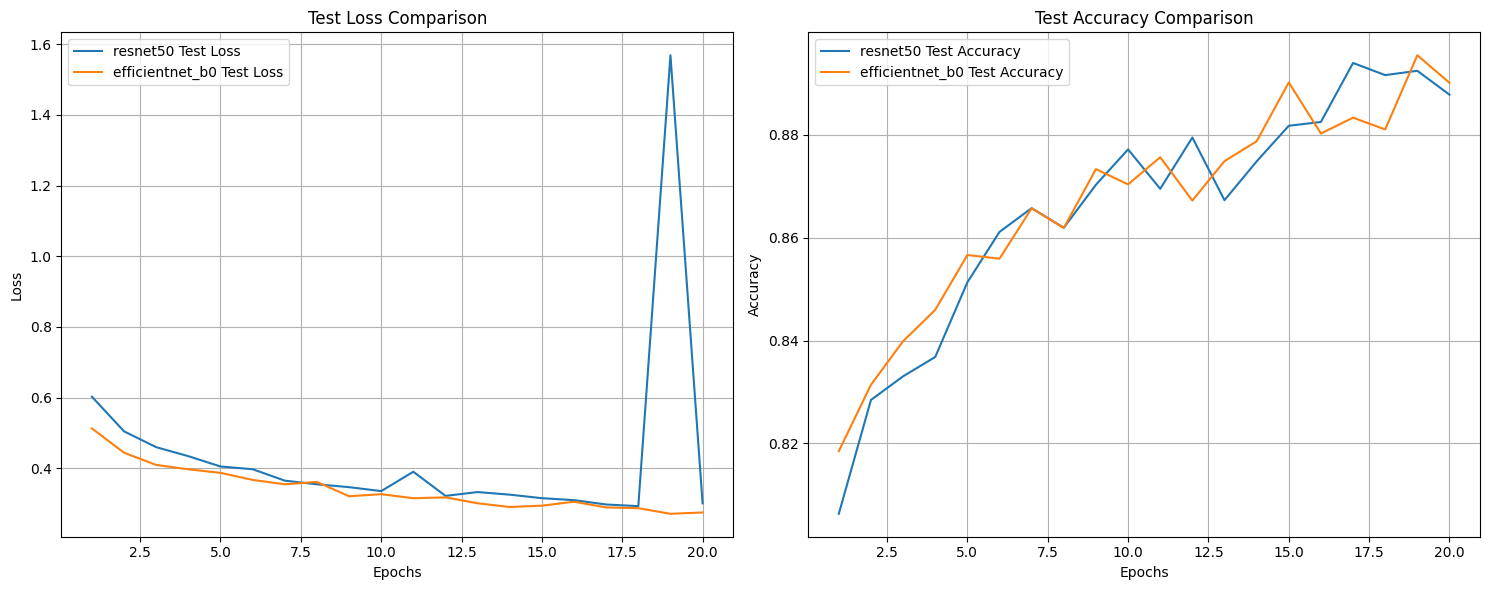

In [13]:
import pandas as pd

# --- Results Analysis ---
print("\n===== Model Comparison =====")

# Calculate final average performance over last epoch (or average over last few)
final_performance = {}
for model_name, results in all_models_results.items():
    final_test_acc = results["test_acc"][-1] # Accuracy from the last epoch
    final_test_loss = results["test_loss"][-1] # Loss from the last epoch
    final_performance[model_name] = {"Test Accuracy": final_test_acc, "Test Loss": final_test_loss}
    print(f"Model: {model_name:15} | Final Test Acc: {final_test_acc:.4f} | Final Test Loss: {final_test_loss:.4f}")

# Convert to DataFrame for easier viewing/sorting (optional)
performance_df = pd.DataFrame.from_dict(final_performance, orient='index')
print("\n--- Performance Summary ---")
print(performance_df.sort_values(by="Test Accuracy", ascending=False))

# Find the best model based on final test accuracy
best_model_name = performance_df["Test Accuracy"].idxmax()
best_accuracy = performance_df["Test Accuracy"].max()
print(f"\nBest performing model: {best_model_name} with Test Accuracy: {best_accuracy:.4f}")


# --- Plotting Learning Curves ---
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 6))

# Plot Loss
plt.subplot(1, 2, 1)
for model_name, results in all_models_results.items():
    plt.plot(epochs_range, results["test_loss"], label=f"{model_name} Test Loss")
    # Optionally plot train loss too (can make plot crowded)
    # plt.plot(epochs_range, results["train_loss"], label=f"{model_name} Train Loss", linestyle='--')
plt.title('Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
for model_name, results in all_models_results.items():
    plt.plot(epochs_range, results["test_acc"], label=f"{model_name} Test Accuracy")
    # Optionally plot train accuracy too
    # plt.plot(epochs_range, results["train_acc"], label=f"{model_name} Train Accuracy", linestyle='--')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# The values we got so far after 10 epochs of training

print(f"Loss values:\n.....................................")
print(f"Average train loss : {sum(train_loss_list)/len(train_loss_list)}")
print(f"Average test loss : {sum(test_loss_list)/len(test_loss_list)}")
print(f"\nLast train loss :{train_loss_list[len(train_loss_list)-1]}")
print(f"Last test loss :{test_loss_list[len(test_loss_list)-1]}")
print(f"\nAccuracy values:\n.....................................")
print(f"Average train accuracy : {sum(train_accuracy_list)/len(train_accuracy_list)*100:.2f}%")
print(f"Average test accuracy: {sum(test_accuracy_list)/len(test_accuracy_list)*100:.2f}%")
print(f"\nLast train accuracy :{train_accuracy_list[len(train_accuracy_list)-1]*100:.2f}%")
print(f"Last test accuracy :{test_accuracy_list[len(test_accuracy_list)-1]*100:.2f}%")

Loss values:
.....................................


NameError: name 'train_loss_list' is not defined